# Re-integrate vacc
for scenario_name, scenario in scenarios.items():
    max_vacc_rate, vacc_total, control_initial = build_scenario(setup, scenario)
    md = pd.read_csv(f'{outdir}{file_prefix}{scenario_name}-{met}{nnodes}.csv', index_col= 'date', parse_dates=True)# Analysis of optimal scenarios agaisnt other scenarios

In [1]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx
from ItalySetup import ItalySetup
from covidOCP import COVIDVaccinationOCP, COVIDParametersOCP
from main import pick_scenario, build_scenario
import seaborn as sns
import datetime
import pickle

nx = 9
states_names = ['S', 'E', 'P', 'I', 'A', 'Q', 'H', 'R', 'V']
when = 'future'
file_prefix = f'week'
#file_prefix = f'2021-01-14_nanoechopc'
#outdir = '2021-01-14_nanoechopc'

myopt = None

n_int_steps = 6
nnodes = 107  # nodes
ndays = 30

setup = ItalySetup(nnodes, ndays, when)
M = setup.nnodes
N = len(setup.model_days) - 1

with open(f'italy-data/parameters_{nnodes}_{when}.pkl', 'rb') as inp:
    p = pickle.load(inp)

Loaded Italy Setup with 107 nodes.


In [2]:
scenarios = {pick_scenario(setup, i)['name']:pick_scenario(setup, i) for i in np.arange(29)}

In [3]:
scenarios.keys()

dict_keys(['U-r1-t125000-id0', 'L-r1-t125000-id1', 'U-r2-t125000-id2', 'L-r2-t125000-id3', 'U-r15-t125000-id4', 'L-r15-t125000-id5', 'U-r1-t250000-id6', 'L-r1-t250000-id7', 'U-r2-t250000-id8', 'L-r2-t250000-id9', 'U-r15-t250000-id10', 'L-r15-t250000-id11', 'U-r1-t479700-id12', 'L-r1-t479700-id13', 'U-r2-t479700-id14', 'L-r2-t479700-id15', 'U-r15-t479700-id16', 'L-r15-t479700-id17', 'U-r1-t1000000-id18', 'L-r1-t1000000-id19', 'U-r2-t1000000-id20', 'L-r2-t1000000-id21', 'U-r15-t1000000-id22', 'L-r15-t1000000-id23', 'U-r1-t2000000-id24', 'L-r1-t2000000-id25', 'U-r2-t2000000-id26', 'L-r2-t2000000-id27', 'U-r15-t2000000-id28'])

In [4]:
# Choose a subset of scenarios:
pick = 'L-r15'
scenarios = {k:v for (k,v) in scenarios.items() if pick in k}
print(len(scenarios))

4


In [5]:
no_vacc = {}
no_vacc['L'] = pd.read_csv(f'2021-01-19-107_30/week-L-r1-t2000000-int-107_30-nc.csv', index_col= 'date', parse_dates=True)
no_vacc['U'] = pd.read_csv(f'2021-01-19-107_30/week-U-r1-t2000000-int-107_30-nc.csv', index_col= 'date', parse_dates=True)

In [6]:
outdir = '2021-01-19-107_30/'

In [7]:
scenarios_opt = {}
## Re-integrate vacc
for scenario_name, scenario in scenarios.items():
    fname = f"{outdir}{file_prefix}-{'-'.join(scenario_name.split('-')[:-1])}-opt-{nnodes}_{ndays}.csv"
    #try:
    md = pd.read_csv(fname, index_col= 'date', parse_dates=True)
    print(f'YES {fname}')
    
    # Build scenario
    maxvaccrate_regional, delivery_national, stockpile_national_constraint, control_initial = build_scenario(setup, scenario)
    M = setup.nnodes
    N = setup.ndays - 1
    control_initial = np.zeros((M, N))
    unvac_nd = np.copy(setup.pop_node)
    stockpile = 0
    for k in range(N):
        stockpile += delivery_national[k]
        for nodename in md.place.unique():
            nd = setup.ind2name.index(nodename)
            to_allocate = md[(md['place'] == nodename) & (md['comp'] == 'vacc')].iloc[k]['value']
            to_allocate = min(to_allocate, maxvaccrate_regional[nd, k], unvac_nd[nd], stockpile)
            control_initial[nd, k] = to_allocate
            stockpile -= to_allocate
            unvac_nd[nd] -= to_allocate
    p.apply_epicourse(setup, scenario['beta_mult'])
    # END Build scenario

    results, state_initial, yell, mob = COVIDVaccinationOCP.integrate(N,
                                                                      setup=setup,
                                                                      parameters=p,
                                                                      controls=control_initial,
                                                                      save_to=f'{outdir}{file_prefix}{scenario_name}-opi-{nnodes}_{ndays}',
                                                                      n_rk4_steps=n_int_steps)
    results.set_index('date', drop=True, inplace=True)
    scenarios_opt[scenario_name] = scenario

#    except FileNotFoundError:
#        print(f'NOT {fname}')

YES 2021-01-19-107_30/week-L-r15-t125000-opt-107_30.csv


 10%|█         | 3/29 [00:00<00:01, 21.62it/s]

===> Integrating for 2021-01-19-107_30/weekL-r15-t125000-id5-opi-107_30


100%|██████████| 29/29 [00:01<00:00, 21.61it/s]


YES 2021-01-19-107_30/week-L-r15-t250000-opt-107_30.csv


 10%|█         | 3/29 [00:00<00:01, 21.44it/s]

===> Integrating for 2021-01-19-107_30/weekL-r15-t250000-id11-opi-107_30


100%|██████████| 29/29 [00:01<00:00, 18.64it/s]


YES 2021-01-19-107_30/week-L-r15-t479700-opt-107_30.csv


 10%|█         | 3/29 [00:00<00:01, 23.21it/s]

===> Integrating for 2021-01-19-107_30/weekL-r15-t479700-id17-opi-107_30


100%|██████████| 29/29 [00:01<00:00, 22.14it/s]


YES 2021-01-19-107_30/week-L-r15-t1000000-opt-107_30.csv


  7%|▋         | 2/29 [00:00<00:01, 18.82it/s]

===> Integrating for 2021-01-19-107_30/weekL-r15-t1000000-id23-opi-107_30


100%|██████████| 29/29 [00:01<00:00, 18.80it/s]


In [8]:
# Generate alternatives:
# BY INCIDENCE: 
for scenario_name, scenario in scenarios_opt.items():
    nv = no_vacc[scenario_name.split('-')[0]]
    incid = nv[nv['comp'].isin(['E', 'P', 'I', 'A', 'Q', 'H', 'R'])].groupby('placeID').sum()
    incid.sort_values('value', ascending=False)
    
    # Build scenario
    maxvaccrate_regional, delivery_national, stockpile_national_constraint, control_initial = build_scenario(setup, scenario)
    M = setup.nnodes
    N = setup.ndays - 1
    control_initial = np.zeros((M, N))
    unvac_nd = np.copy(setup.pop_node)
    stockpile = 0
    for k in range(N):
        stockpile += delivery_national[k]
        for nodename in md.place.unique():
            nd = setup.ind2name.index(nodename)
            to_allocate = stockpile * incid.loc[nd]['value'] / incid['value'].sum()
            to_allocate = min(to_allocate, maxvaccrate_regional[nd, k], unvac_nd[nd], stockpile)
            control_initial[nd, k] = to_allocate
            stockpile -= to_allocate
            unvac_nd[nd] -= to_allocate
    p.apply_epicourse(setup, scenario['beta_mult'])
    # END Build scenario

    results, state_initial, yell, mob = COVIDVaccinationOCP.integrate(N,
                                                                      setup=setup,
                                                                      parameters=p,
                                                                      controls=control_initial,
                                                                      save_to=f'{outdir}{file_prefix}{scenario_name}-inc-{nnodes}_{ndays}',
                                                                      n_rk4_steps=n_int_steps)
    results.set_index('date', drop=True, inplace=True)

# BY Suceptibility: 
for scenario_name, scenario in scenarios_opt.items():
    nv = no_vacc[scenario_name.split('-')[0]]
    incid = nv[nv['comp'].isin(['S'])].loc[str(setup.start_date)]
    incid.set_index('placeID', inplace=True)
    
    # Build scenario
    maxvaccrate_regional, delivery_national, stockpile_national_constraint, control_initial = build_scenario(setup, scenario)
    M = setup.nnodes
    N = setup.ndays - 1
    control_initial = np.zeros((M, N))
    unvac_nd = np.copy(setup.pop_node)
    stockpile = 0
    for k in range(N):
        stockpile += delivery_national[k]
        for nodename in md.place.unique():
            nd = setup.ind2name.index(nodename)
            to_allocate = stockpile * incid.loc[nd]['value'] / incid['value'].sum()
            to_allocate = min(to_allocate, maxvaccrate_regional[nd, k], unvac_nd[nd], stockpile)
            control_initial[nd, k] = to_allocate
            stockpile -= to_allocate
            unvac_nd[nd] -= to_allocate
    p.apply_epicourse(setup, scenario['beta_mult'])
    # END Build scenario

    results, state_initial, yell, mob = COVIDVaccinationOCP.integrate(N,
                                                                      setup=setup,
                                                                      parameters=p,
                                                                      controls=control_initial,
                                                                      save_to=f'{outdir}{file_prefix}{scenario_name}-sus-{nnodes}_{ndays}',
                                                                      n_rk4_steps=n_int_steps)
    results.set_index('date', drop=True, inplace=True)
    

    
# BY POPULATION 
for scenario_name, scenario in scenarios_opt.items():
    # Build scenario
    maxvaccrate_regional, delivery_national, stockpile_national_constraint, control_initial = build_scenario(setup, scenario)
    M = setup.nnodes
    N = setup.ndays - 1
    control_initial = np.zeros((M, N))
    unvac_nd = np.copy(setup.pop_node)
    stockpile = 0
    for k in range(N):
        stockpile += delivery_national[k]
        for nodename in md.place.unique():
            pop_nd = setup.pop_node[nd]
            nd = setup.ind2name.index(nodename)
            to_allocate = stockpile * pop_nd / setup.pop_node.sum()
            to_allocate = min(to_allocate, maxvaccrate_regional[nd, k], unvac_nd[nd], stockpile)
            control_initial[nd, k] = to_allocate
            stockpile -= to_allocate
            unvac_nd[nd] -= to_allocate
    p.apply_epicourse(setup, scenario['beta_mult'])
    # END Build scenario

    results, state_initial, yell, mob = COVIDVaccinationOCP.integrate(N,
                                                                      setup=setup,
                                                                      parameters=p,
                                                                      controls=control_initial,
                                                                      save_to=f'{outdir}{file_prefix}{scenario_name}-pop-{nnodes}_{ndays}',
                                                                      n_rk4_steps=n_int_steps)
    results.set_index('date', drop=True, inplace=True)
    

#TODO: Centrality based and R0 based

 10%|█         | 3/29 [00:00<00:01, 20.86it/s]

===> Integrating for 2021-01-19-107_30/weekL-r15-t125000-id5-inc-107_30


  7%|▋         | 2/29 [00:00<00:01, 16.28it/s]

===> Integrating for 2021-01-19-107_30/weekL-r15-t250000-id11-inc-107_30


 10%|█         | 3/29 [00:00<00:01, 21.60it/s]

===> Integrating for 2021-01-19-107_30/weekL-r15-t479700-id17-inc-107_30


 10%|█         | 3/29 [00:00<00:01, 20.01it/s]

===> Integrating for 2021-01-19-107_30/weekL-r15-t1000000-id23-inc-107_30


  7%|▋         | 2/29 [00:00<00:01, 18.65it/s]

===> Integrating for 2021-01-19-107_30/weekL-r15-t125000-id5-sus-107_30


 10%|█         | 3/29 [00:00<00:01, 22.06it/s]

===> Integrating for 2021-01-19-107_30/weekL-r15-t250000-id11-sus-107_30


 17%|█▋        | 5/29 [00:00<00:01, 19.84it/s]

===> Integrating for 2021-01-19-107_30/weekL-r15-t479700-id17-sus-107_30


 14%|█▍        | 4/29 [00:00<00:01, 16.45it/s]

===> Integrating for 2021-01-19-107_30/weekL-r15-t1000000-id23-sus-107_30


  7%|▋         | 2/29 [00:00<00:01, 19.70it/s]

===> Integrating for 2021-01-19-107_30/weekL-r15-t125000-id5-pop-107_30


  7%|▋         | 2/29 [00:00<00:01, 18.53it/s]

===> Integrating for 2021-01-19-107_30/weekL-r15-t250000-id11-pop-107_30


 10%|█         | 3/29 [00:00<00:01, 19.60it/s]

===> Integrating for 2021-01-19-107_30/weekL-r15-t479700-id17-pop-107_30


  7%|▋         | 2/29 [00:00<00:01, 18.61it/s]

===> Integrating for 2021-01-19-107_30/weekL-r15-t1000000-id23-pop-107_30


100%|██████████| 29/29 [00:01<00:00, 19.07it/s]


In [9]:
scn_results = pd.DataFrame(columns=['newdoseperweek', 'method', 'infected'])
methods = ['opi', 'inc', 'pop', 'sus'] # 'opt'
for met in methods:
    for scenario_name, scenario in scenarios_opt.items():
        maxvaccrate_regional, stockpile_national, stockpile_national_constraint, control_initial = build_scenario(setup, scenario)
        dosesperweek = int(scenario_name.split('-')[2][1:])
        ratepermonth = int(scenario_name.split('-')[1][1:])*1e6
        md = pd.read_csv(f'{outdir}{file_prefix}{scenario_name}-{met}-{nnodes}_{ndays}.csv', index_col= 'date', parse_dates=True)
        print(f'{outdir}{file_prefix}{scenario_name}-{met}-{nnodes}_{ndays}.csv')
        infected = md[md['comp'].isin(['E', 'P', 'I', 'A', 'Q', 'H', 'R']) & (md.index == str(setup.end_date))]['value'].sum()
        doses = md[md['comp']=='vacc']['value'].sum()
        nv = no_vacc[scenario_name.split('-')[0]]
        baseline_infected = nv[(nv['comp'].isin(['E', 'P', 'I', 'A', 'Q', 'H', 'R'])) & (nv.index == str(setup.end_date))]['value'].sum()
        scn_results = pd.concat([scn_results, pd.DataFrame.from_dict({'newdoseperweek':[dosesperweek],
                                                                      'method': [met],
                                                                      'infected':[infected],
                                                                       'doses': [doses],
                                                                       'scenario-beta': [scenario_name.split('-')[0]],
                                                                       'scenario-rate': [scenario_name.split('-')[1]],
                                                                       'scenario-tot': [scenario_name.split('-')[2]],
                                                                       'averted': baseline_infected - infected
                                                                     })])                      
   
scn_results['avertedpervacc'] = scn_results['averted']/scn_results['doses']

2021-01-19-107_30/weekL-r15-t125000-id5-opi-107_30.csv
2021-01-19-107_30/weekL-r15-t250000-id11-opi-107_30.csv
2021-01-19-107_30/weekL-r15-t479700-id17-opi-107_30.csv
2021-01-19-107_30/weekL-r15-t1000000-id23-opi-107_30.csv
2021-01-19-107_30/weekL-r15-t125000-id5-inc-107_30.csv
2021-01-19-107_30/weekL-r15-t250000-id11-inc-107_30.csv
2021-01-19-107_30/weekL-r15-t479700-id17-inc-107_30.csv
2021-01-19-107_30/weekL-r15-t1000000-id23-inc-107_30.csv
2021-01-19-107_30/weekL-r15-t125000-id5-pop-107_30.csv
2021-01-19-107_30/weekL-r15-t250000-id11-pop-107_30.csv
2021-01-19-107_30/weekL-r15-t479700-id17-pop-107_30.csv
2021-01-19-107_30/weekL-r15-t1000000-id23-pop-107_30.csv
2021-01-19-107_30/weekL-r15-t125000-id5-sus-107_30.csv
2021-01-19-107_30/weekL-r15-t250000-id11-sus-107_30.csv
2021-01-19-107_30/weekL-r15-t479700-id17-sus-107_30.csv
2021-01-19-107_30/weekL-r15-t1000000-id23-sus-107_30.csv


In [10]:
#scn_results.replace('opt', 'Optimal', inplace=True)
scn_results.replace('opi', 'Optimal', inplace=True)
scn_results.replace('int', 'Uniform', inplace=True)
scn_results.replace('inc', 'Incidence', inplace=True)
scn_results.replace('pop', 'Population', inplace=True)
scn_results.replace('sus', 'Susceptibility', inplace=True)

In [ ]:
scn_results[scn_results['scenario-rate']=='r15']

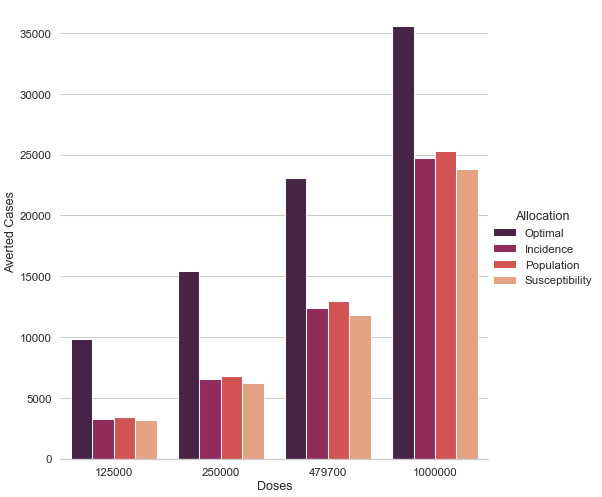

In [11]:
#fig, ax = plt.subplots(figsize=(10,10))
sns.set(rc={'figure.figsize':(10,5), 'figure.dpi':50})
sns.set_theme(style="whitegrid")
sns.set_context("talk")

g = sns.catplot(
    data=scn_results,#[(scn_results['scenario-rate']=='r2') & (scn_results['scenario-beta']=='U')],
    kind="bar",
    x="newdoseperweek",
    #y="avertedpervacc", 
    y="averted",
    hue="method",
    palette="rocket",
    #alpha=.9, 
    height=10,
)
g.despine(left=True)
#g.fig.suptitle(f'Simulation on {setup.ndays} days, rate of 7.5M per month')
g.set_axis_labels("Doses", "Averted Cases")
g.legend.set_title("Allocation")
#g.set_xticklabels([str(i/1e6)+'M' for i in np.sort(scn_results['total_vacc'].unique())])

In [44]:
[f"{str(i/1e6)}M" for i in np.sort(scn_results['total_vacc'].unique())]

['2.0M', '5.0M', '10.0M', '15.0M']

In [32]:
g = sns.lineplot(
    data=scn_results, 
    x="total_vacc", y="averted", hue="method",
    palette="rocket", marker = 'o', 
    #alpha=.9, 
)

ValueError: Could not interpret value `total_vacc` for parameter `x`

In [34]:
#fig, ax = plt.subplots(figsize=(10,10))
sns.set(rc={'figure.figsize':(10,5), 'figure.dpi':50})
sns.set_theme(style="whitegrid")
sns.set_context("talk")
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=scn_results, kind="bar",
    x="method", 
    #y="avertedpervacc", 
    #x='total_vacc',
    y="averted",
    hue="method",
    col="total_vacc",
    palette="viridis",
    #alpha=.9, 
    height=5,
    aspect = .5,
    #width = 10
)
g.despine(left=True)
#g.fig.suptitle(f'Simulation on {setup.ndays} days, rate of 7.5M per month')
g.set_axis_labels("Strategy", "Averted Cases")
#g.legend.set_title("Allocation")
g.set_xticklabels([str(i/1e6)+'M' for i in np.sort(scn_results['total_vacc'].unique())])
(g.set_axis_labels("", "Averted Cases")
#.set_xticklabels(["Men", "Women", "Children"])
.set_titles("{col_name}")
#.set(ylim=(0, 1))
.despine(left=True))
g.set_xticklabels(rotation=-90)

KeyError: 'total_vacc'

In [ ]:
¶

In [ ]:
g = sns.catplot(
    data=scn_results, kind="point",
    x="total_vacc", y="averted", hue="method",
    palette="rocket",
    #alpha=.9, 
    height=10,
)
g.despine(left=True)
g.set_axis_labels("", "Averted Cases")
g.legend.set_title("Allocation")
g.set_xticklabels([str(i/1e6)+'M' for i in np.sort(scn_results['total_vacc'].unique())])